In [3]:
from seligator.main import train_and_get, Seligator
from seligator.common.load_save import load
from seligator.prediction.tests import run_tests
from seligator.common.params import Seq2VecEncoderType, BertPoolerClass
import csv
conf = load("./seligator/best-nometadata.json")
print(conf)
conf["token_features"] = ("token_subword", )
conf["msd_features"] = []
conf["seq2vec_encoder_type"] = Seq2VecEncoderType.BERT_ONLY
conf["model_embedding_kwargs"]["pretrained_embeddings"] = {}
conf["bert_layer"] = -1
conf["bert_mode"] = BertPoolerClass.HAN
conf["encoder_hidden_size"] = 128

scores = ['accuracy', 'precision', 'recall', 'fscore', 
                'precision-negative', 'precision-positive', 
                'recall-negative', 'recall-positive', 'fscore-negative', 'fscore-positive', 'loss']


def train_and_test(configuration, dump=0):
    seligator, reader, train, dev = Seligator.init_from_params(folder="dataset/main-partial/", **configuration)
    train_kwargs = dict(patience=4, num_epochs=1, lr=5e-4, optimizer="AdamW")
    # print(seligator.model)
    model, metrics = train_and_get(seligator.model, train, dev, return_metrics=True, **train_kwargs)
    data, img = run_tests(
        "dataset/main/test.txt",
        dataset_reader=reader, model=model, dump=f"test{dump}.best.csv"
    )
    
    bert_expriment_pool = open(f"bert_experiment_results.{dump}.csv", "w")
    writer = csv.DictWriter(
        bert_expriment_pool,
        fieldnames=["bert_layer", "bert_mode", "bert_trainable", 
                    "epoch", "best_epoch",
                    "training_duration", 
                    *scores,
                    *["training_"+score for score in scores],
                    *["validation_"+score for score in scores]
                   ]
    )
    writer.writeheader()
    writer.writerow({
        **data,
        **{key: conf[key] for key in ("bert_layer", "bert_mode", "bert_trainable")},
        **{key: metrics[key] for key in ("epoch", "best_epoch", "training_duration")},
        **{"training_"+key: metrics["training_"+key] for key in scores},
        **{"validation_"+key: metrics["validation_"+key] for key in scores}
    })
    bert_expriment_pool.close()
    return seligator

{'token_features': ['lemma_char', 'lemma'], 'msd_features': ['case', 'numb', 'gend', 'mood', 'tense', 'voice', 'person', 'deg'], 'seq2vec_encoder_type': <Seq2VecEncoderType.HAN: 1>, 'basis_vector_configuration': <BasisVectorConfiguration cats='Century,WrittenType' />, 'agglomerate_msd': True, 'reader_kwargs': {'batch_size': 4, 'metadata_encoding': <MetadataEncoding.AS_CATEGORICAL: 2>, 'metadata_tokens_categories': ['Century', 'WrittenType']}, 'model_embedding_kwargs': {'keep_all_vocab': True, 'pretrained_embeddings': {'lemma': '~/dev/these/notebooks/4 - Detection/data/embs_models/model.lemma.word2vec.kv.header'}, 'trainable_embeddings': {'token': False, 'lemma': False}, 'emb_dims': {'token': 200, 'lemma': 200}}, 'model_class': <class 'seligator.models.classifier.FeatureEmbeddingClassifier'>, 'use_bert_highway': False, 'additional_model_kwargs': {'metadata_linear': True}}


In [4]:
i = 0
for bert_layer in (-1, -2):
    for bert_mode in (
            BertPoolerClass.EnrichedAttention, BertPoolerClass.EnrichedLSTM):
        for bert_trainable in (False, ):
            if bert_trainable == True and bert_layer == -2:
                # We skip those (layer-2 for no retraining)
                continue
            conf["bert_layer"] = bert_layer
            conf["bert_mode"] = bert_mode
            conf["bert_trainable"] = bert_trainable
            for _ in range(5):
                train_and_test(conf, dump=i)
                i += 1
                break
            break
        break
    break

Some weights of the model checkpoint at ./bert/latin_bert were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


ValueError: `set_metadata_categories_dim` was never run on BasisVectorConfiguration

In [ ]:
# bert_expriment_pool.close()

## Results

### Layer - 1

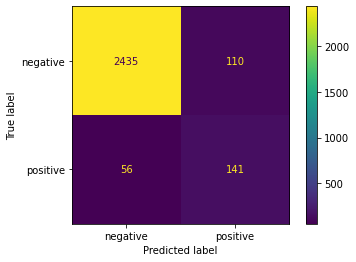

accuracy: 0.94
precision: 0.84
recall: 0.77
fscore: 0.80
precision-negative: 0.96
precision-positive: 0.72
recall-negative: 0.98
recall-positive: 0.56
fscore-negative: 0.97
fscore-positive: 0.63
loss: 0.16


neg/2435/110
pos/56/141
/neg/pos


### Layers -1 Run 2

accuracy: 0.93, precision: 0.82, recall: 0.75, fscore: 0.78, precision-negative: 0.95, precision-positive: 0.69, recall-negative: 0.98, recall-positive: 0.52, fscore-negative: 0.96, fscore-positive: 0.59, loss: 0.16 ||: 

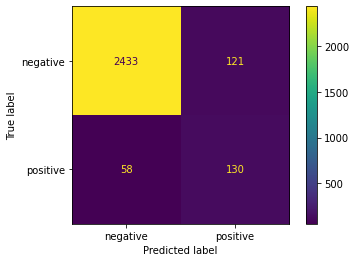

### Layers -1 Run 3

accuracy: 0.94, precision: 0.83, recall: 0.74, fscore: 0.77, precision-negative: 0.95, precision-positive: 0.71, recall-negative: 0.98, recall-positive: 0.49, fscore-negative: 0.96, fscore-positive: 0.58, loss: 0.16

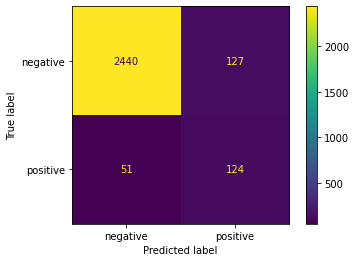